In [1]:
#|default_exp sgd

# Accelerated SGD

Note - see also the excel spreadsheet in the xl folder.

This notebook is covered in course video towards the end of lesson 17 and then lesson 18
[Lesson 17](https://www.youtube.com/watch?v=vGsc_NbU7xc)

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStatsCB(append_stats, fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

In [6]:
append_stats

<function miniai.activations.append_stats(hook, mod, inp, outp)>

## Optimizers 

### SGD

In [13]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1
    
    def opt_step(self, p):
        p -= self.lr * p.grad
    
    def reg_step(self, p):
        # regularisation step with weight decay
        if self.wd != 0:
            p *= 1.0 - self.lr * self.wd
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [14]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.772,0.641,0,True
0.810,0.505,0,False
0.844,0.432,1,True
0.849,0.425,1,False
0.862,0.380,2,True
0.857,0.401,2,False


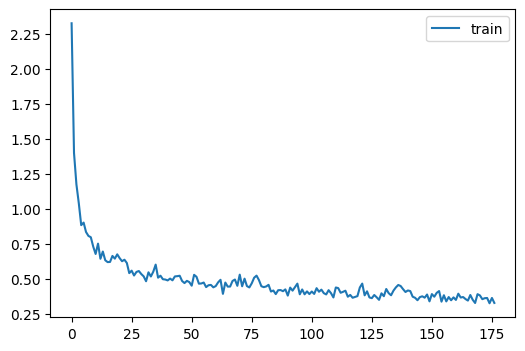

In [15]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

### Momentum 

In [16]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

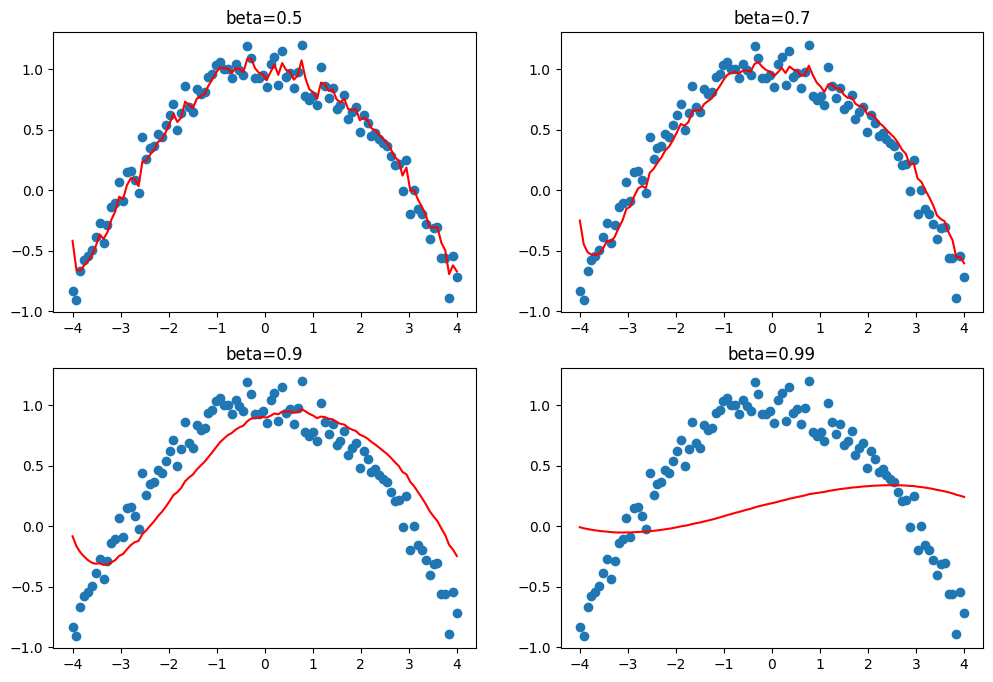

In [17]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

It can be seen that as beta increases so the response if more smoothed and also that there is a phase shift before the response reacts to changes to the raw data

In [21]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0, mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom
        
    def opt_step(self, p):
        """ The average gradient to be used in the momentum calculation will be added to the parameters as
        a property.  This will then be used to feed into the parameter update
        """
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        # Update the grad average using the latest grads
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr*p.grad_avg

In [22]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.783,0.595,0,True
0.843,0.438,0,False
0.868,0.365,1,True
0.866,0.368,1,False
0.883,0.321,2,True
0.874,0.347,2,False


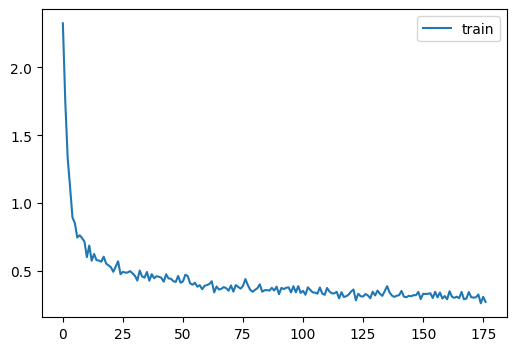

In [23]:
learn.fit(3)

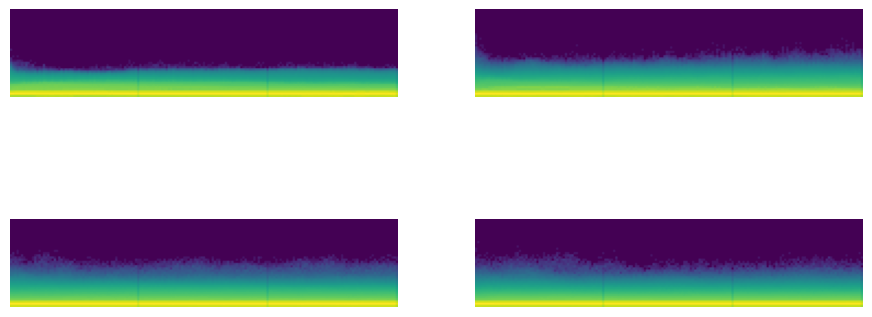

In [24]:
astats.color_dim()

In [25]:
len(astats)

4

### RMS Prop 

RMS Prop works with the square of the gradients

In [26]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1.E-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps
        
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg=p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr*p.grad/(p.sqr_avg.sqrt() + self.eps)
    

accuracy,loss,epoch,train
0.771,0.653,0,True
0.821,0.495,0,False
0.847,0.418,1,True
0.848,0.423,1,False
0.863,0.370,2,True
0.856,0.399,2,False


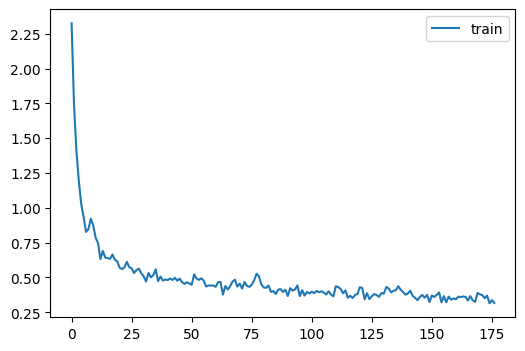

In [27]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3E-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

### Adam 

Adam uses momentum as well as the square momentum terms

In [28]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1.e-5):
        super.__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
    
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg=p.grad**2
        p.avg = self.beta1*p.grad_avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1-(self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1-(self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

In [29]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.578,0,True
0.843,0.436,0,False
0.866,0.368,1,True
0.864,0.381,1,False
0.883,0.322,2,True
0.875,0.350,2,False


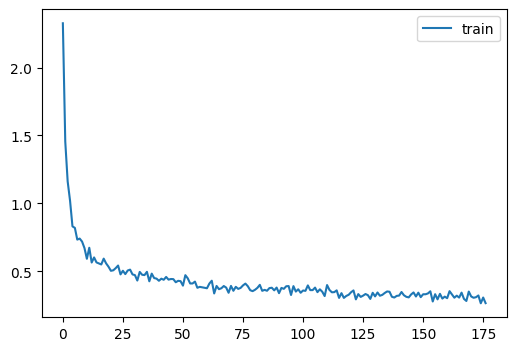

In [30]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6E-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

### Schedulers 

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [31]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [32]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [33]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [34]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [35]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [36]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [37]:
st

{'momentum_buffer': None}

In [38]:
len(opt.param_groups)

1

In [39]:
pg = opt.param_groups[0]

In [40]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

In [41]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [43]:
sched.base_lrs

[0.006]

In [44]:
sched.get_last_lr()

[0.006]

In [45]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

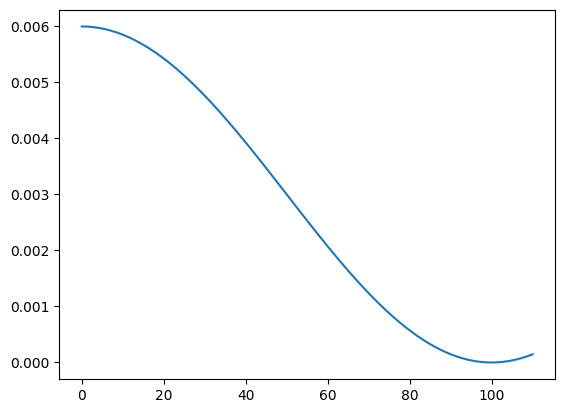

In [46]:
sched_lrs(sched, 110)

### Scheduler callbacks

In [47]:
#|export
class BaseSchedCB(Callback):
    """ define the scheduler to use and assign the optimiser.  Create a basic step operation for the 
    scheduler
    """
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [48]:
#|export
class BatchSchedCB(BaseSchedCB):
    """ step the scheduler after the batch
    """
    def after_batch(self, learn): self._step(learn)

In [49]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [50]:
#|export
class RecorderCB(Callback):
    """ Class to record specific keyword items during training
    """
    def __init__(self, **d): 
        self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [51]:
def _lr(cb):
    """ Provide a function to return the learning rate for a specific parameter group
    """
    return cb.pg['lr']

In [52]:
pg = opt.param_groups[0]
pg['lr']

0.00014683045111453906

In [53]:
len(dls.train)

59

In [67]:
# set the maximum number of iterations to correspond to three epochs
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

Note that the function `_lr` works because the before fit method of the recorder assigns the first parameter group to the self.pg attribute, hence this will return the learning rate as required

accuracy,loss,epoch,train
0.796,0.551,0,True
0.854,0.402,0,False
0.875,0.345,1,True
0.870,0.355,1,False
0.890,0.303,2,True
0.874,0.342,2,False


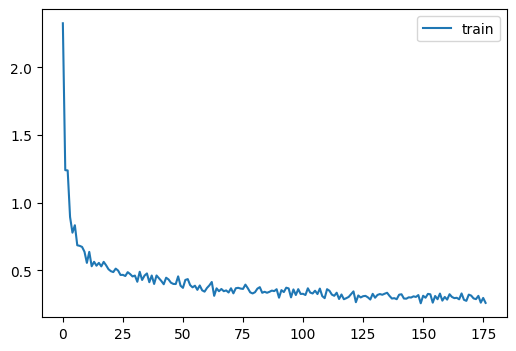

In [68]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

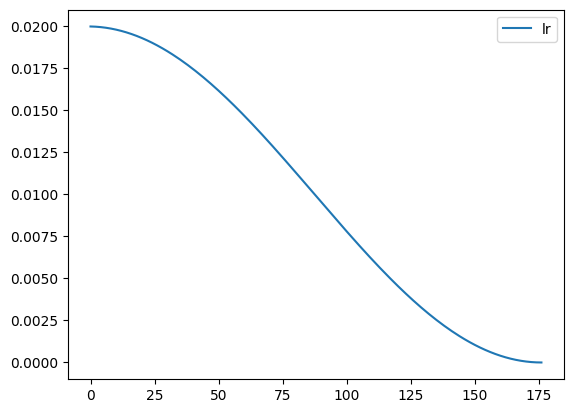

In [69]:
rec.plot()

In [62]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.795,0.551,0,True
0.850,0.413,0,False
0.874,0.346,1,True
0.874,0.345,1,False
0.893,0.294,2,True
0.879,0.328,2,False


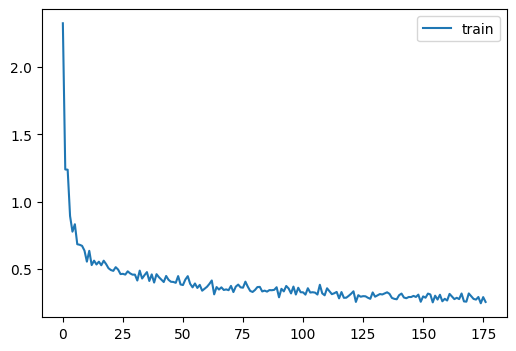

In [58]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

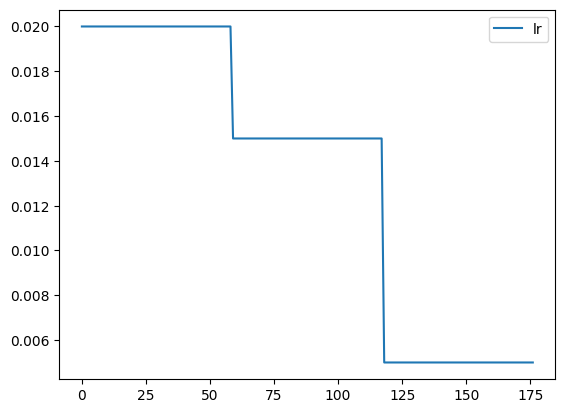

In [59]:
rec.plot()

### 1cycle training 

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [63]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.773,0.641,0,True
0.818,0.549,0,False
0.850,0.409,1,True
0.860,0.415,1,False
0.886,0.311,2,True
0.882,0.334,2,False
0.903,0.266,3,True
0.891,0.300,3,False
0.917,0.227,4,True
0.898,0.282,4,False


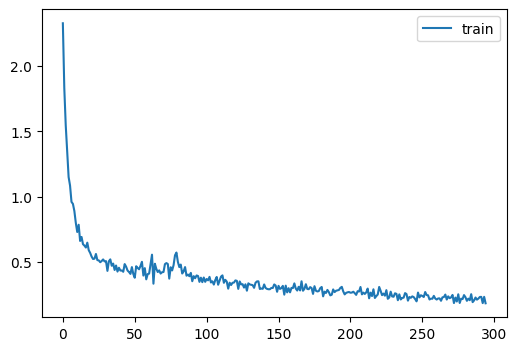

In [64]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [65]:
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

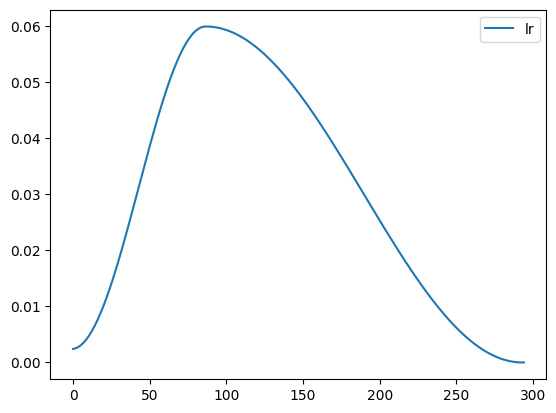

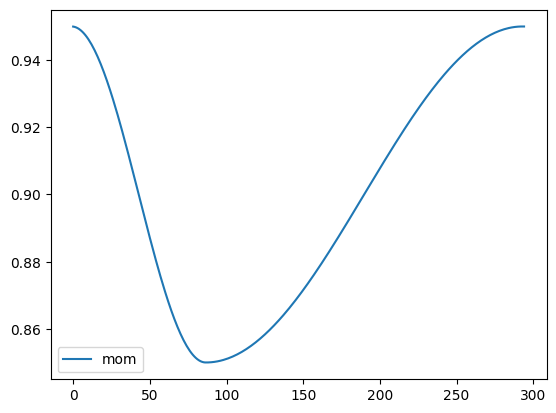

In [66]:
rec.plot()

## Export 

In [70]:
import nbdev; nbdev.nbdev_export()